In [2]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model
import time
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import math

from scipy import ndimage
import pandas as pd

In [3]:
def plot_metrics(train_metric, val_metric=None, metric_name1=None, metric_name12=None, title=None, ylim=5, ylim_low=0):
    plt.title(title)
    plt.ylim(ylim_low,ylim)
    plt.plot(train_metric, color='blue',label=metric_name1)
    if val_metric is not None: plt.plot(val_metric,color='green',label=metric_name12)
    plt.legend(loc="upper right")
    plt.show()


In [103]:
def generate_scores(x, seed=None):
    np.random.seed(seed)
    d = x.shape[1]
    rng = np.random.default_rng(seed)
    term1 = x.dot(np.random.uniform(low=-1, high=1, size=(d)))
    term2 = np.sum(np.multiply(x, rng.permutation(x, 1)), 1)
    term3 = np.sum(np.multiply(np.multiply(x, rng.permutation(x, 1)), rng.permutation(x, 1)), 1)
    # normalize
    term1 = (term1 - np.mean(term1)) / np.std(term1)
    term2 = (term2 - np.mean(term2)) / np.std(term2)
    term3 = (term3 - np.mean(term3)) / np.std(term3)
    scores = (term1 + term2 + term3) / 3
    #scores = (term1 + term2) / 2
    scores = np.digitize(scores, bins = np.array([-1, -0.5, 0, 0.5, 1]), right=False)
    return np.clip(np.round(scores), 0., 5.).astype(np.float32)

In [8]:
# generate data
# split is based on queries, each query are either kept for training/testing only
def generate_data(nb_query=25, mean_doc_per_query=10, features=10, test_size=0.2, seed=None):
    np.random.seed(seed)
    query = np.repeat(np.arange(nb_query)+1, np.ceil(np.abs(np.random.normal(mean_doc_per_query, size=nb_query, scale=0.15*mean_doc_per_query))+2).astype(np.int))
    doc_features = np.random.uniform(low=-1, high=1, size=(len(query), features)) # np.random.random((len(query), 10))
    doc_scores = generate_scores(doc_features, seed=seed) # np.random.randint(5, size=len(query)).astype(np.float32)

    # put data into pairs
    pair_id_train = []
    pair_id_test = []
    pair_query_id_train = []
    pair_query_id_test = []
    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        if np.random.random() < test_size:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_test.append(q)        
                pair_id_test.append(pair_idx)
        else:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_train.append(q)        
                pair_id_train.append(pair_idx)
         
    pair_id_train = np.array(pair_id_train)
    pair_id_test = np.array(pair_id_test)
    pair_query_id_train = np.array(pair_query_id_train)
    pair_query_id_test = np.array(pair_query_id_test)

    return query, doc_features, doc_scores, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test


In [9]:
def get_data(query_id, pair_id, pair_query_id):
    if type(query_id) is not np.ndarray:
        query_id = np.array([query_id]).ravel()
    _ind = np.hstack([np.where(query==i) for i in query_id]).ravel()

    q_unique, q_index, q_cnt  = np.unique(query, return_index=True, return_counts=True)
    doc_cnt = q_cnt[np.searchsorted(q_unique, query_id)].sum()
    x = doc_features[_ind]
    score = doc_scores[_ind]
    
    mask = np.zeros((doc_cnt, doc_cnt), dtype=np.float32)
    _, new_q_index = np.unique(query[_ind], return_index=True)
    _pair_id = np.vstack([pair_id[np.where(pair_query_id==i)] - q_index[q_unique==i] + new_q_index[query_id==i] for i in query_id])
    mask[_pair_id[:,0], _pair_id[:,1]] = 1

    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(score, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32), tf.convert_to_tensor(doc_cnt, dtype=tf.float32)


In [231]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu, kernel_regularizer='l2'), layers.Dense(8, activation=leaky_relu, kernel_regularizer='l2')]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))


class FactorisedRankNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu, kernel_regularizer='l2'), layers.Dense(8, activation=leaky_relu, kernel_regularizer='l2')]
        self.o = layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        xi = inputs
        densei = self.dense[0](xi)
        for dense in self.dense[1:]:
            densei = dense(densei)
        oi = self.o(densei)
        return oi
    
    def build_graph(self):
        x = tf.keras.Input(shape=(10))
        return tf.keras.Model(inputs=x, outputs=self.call(x))
        

In [12]:
def eval_ndcg(score, score_pred, return_ndcg_delta=False, eval_at=tf.Variable([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])):
    """
    calculates ndcg
    input should be documents' score of ONE query only
    """
    argsort_score = tf.argsort(score, direction='DESCENDING')
    argsort_score_pred = tf.argsort(score_pred, direction='DESCENDING')
    rank_plus_one = tf.dtypes.cast(tf.add(tf.argsort(argsort_score), 2), tf.float32)
    rank_plus_one_pred = tf.dtypes.cast(tf.add(tf.argsort(argsort_score_pred), 2), tf.float32)
    
    numerator = tf.subtract(tf.pow(2., score), 1)
    idcg_denominator = tf.experimental.numpy.log2(rank_plus_one)
    dcg_denominator = tf.experimental.numpy.log2(rank_plus_one_pred)
    idcg = tf.divide(numerator, idcg_denominator)
    dcg = tf.divide(numerator, dcg_denominator)
    
    # calculate ndcg_delta if i and j swapped position
    if return_ndcg_delta is True:
        # numerator_{ij} = 2^{rel_{i}} - 2^{rel_{j}}
        numerator_ij = tf.subtract(tf.expand_dims(numerator, -1), numerator)
        # dcg_denominator_{ij} = \frac{1}{log(Rank_{i}+1)} - \frac{1}{log(Rank_{j}+1)}
        dcg_denominator_ij = tf.subtract(tf.expand_dims(dcg_denominator, -1), dcg_denominator)
        # ndcg_delta_ij = absolute change in ndcg is i and j swapped position
        ndcg_delta_ij = tf.abs(tf.divide(tf.multiply(numerator_ij, dcg_denominator_ij), tf.maximum(tf.reduce_sum(idcg), 0.001)))

    # calculate ndcg@all
    ndcg = tf.TensorArray(tf.float32, size=tf.shape(eval_at)[0]+1)
    ndcg = ndcg.write(0, tf.divide(tf.reduce_sum(dcg), tf.maximum(tf.reduce_sum(idcg), 0.001)))
    
    # calculate ndcg@k per eval_at position
    if eval_at is not None:
        idcg = tf.gather(idcg, argsort_score)
        dcg = tf.gather(dcg, argsort_score_pred)
        
        def ndcg_at_k(i, ndcg):
            k = eval_at[i]
            ndcg = ndcg.write(i+1, tf.divide(tf.reduce_sum(dcg[:k]), tf.maximum(tf.reduce_sum(idcg[:k]), 0.001)))
            return (tf.add(i, 1), ndcg)

        i = tf.constant(0)
        _, ndcg = tf.while_loop(lambda i, _: tf.less(i, tf.shape(eval_at)[0]), ndcg_at_k, [i, ndcg])
    
    if return_ndcg_delta is True:
        return ndcg.stack(), ndcg_delta_ij
    else:
        return ndcg.stack()

eval_ndcg_graph = tf.function(eval_ndcg)
a, b = eval_ndcg_graph(np.array([3,3,2,2,1]).astype(np.float32),np.array([3,3,4,1,2.5]).astype(np.float32), return_ndcg_delta=True)
a

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.8569653 , 0.42857143, 0.6496302 , 0.8451594 , 0.79861736,
       0.8569653 , 0.8569653 , 0.8569653 , 0.8569653 , 0.8569653 ,
       0.8569653 , 0.8569653 , 0.8569653 , 0.8569653 , 0.8569653 ,
       0.8569653 ], dtype=float32)>

In [13]:
def apply_gradient_factorised(optimizer, model, x, score, mask, doc_cnt, eval_ndcg):
    with tf.GradientTape() as tape:
        oi = model(x)
    
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)
    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)
    
    doi_dwk = tape.jacobian(oi, model.trainable_weights)
    
    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k: 
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))
    
    # model could still be trained without calculating the loss below
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)
    
    # ndcg
    ndcg = eval_ndcg(score, tf.squeeze(oi, 1))
    
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return oi, loss_value, ndcg

In [14]:
# this function will do update per query
def train_data_for_one_epoch_factorised(optimizer, model, batch_size=1, apply_gradient=apply_gradient_factorised, eval_ndcg=eval_ndcg):
    losses = []
    losses_ndcg = []
    
    pb_i = Progbar(np.ceil(len(np.unique(pair_query_id_train)) // batch_size), stateful_metrics=['loss'])
    _query = np.unique(pair_query_id_train)
    np.random.shuffle(_query)
    for step, query_id in enumerate(_query):
        x, score, mask, doc_cnt= get_data(query_id, pair_id_train, pair_query_id_train)
        y_pred, loss_value, ndcg_value = apply_gradient(optimizer, model, x, score, mask, doc_cnt, eval_ndcg)
        losses.append(loss_value)
        losses_ndcg.append(ndcg_value)
        
        pb_i.add(1)
    return losses, losses_ndcg


In [15]:
def compute_val_loss(model, x, score, mask, doc_cnt, eval_ndcg):
    oi = model(x)
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)
    
    ndcg = eval_ndcg(score, tf.squeeze(oi, 1))
    
    return loss_value, ndcg


In [16]:
def validate_data_for_one_epoch(model, compute_val_loss, eval_ndcg):
    losses = []
    losses_ndcg = []
    
    _query_ids = np.unique(pair_query_id_test)
    for step, query_id in enumerate(_query_ids):
        x, score, mask, doc_cnt = get_data(query_id, pair_id_test, pair_query_id_test)
        loss_value, ndcg_value = compute_val_loss(model, x, score, mask, doc_cnt, eval_ndcg)
        losses.append(loss_value)
        losses_ndcg.append(ndcg_value)
        
    return losses, losses_ndcg


# RankNet Factorised

In [215]:
def train_ranknet():
    time_start = time.perf_counter()

    # init optimizer
    optimizer = tf.keras.optimizers.Adam()

    # start training
    fac_ranknet = FactorisedRankNet()

    epochs = 200
    early_stop_patience = 20
    loss_train_history = []
    loss_val_history = []
    ndcg_train_history = []
    ndcg_val_history = []

    apply_gradient_graph = tf.function(apply_gradient_factorised, experimental_relax_shapes=True)
    compute_val_loss_graph = tf.function(compute_val_loss, experimental_relax_shapes=True)
    eval_ndcg_graph = tf.function(eval_ndcg)

    for epoch in range(epochs):
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train, ndcg_train = train_data_for_one_epoch_factorised(optimizer, fac_ranknet, apply_gradient=apply_gradient_graph, eval_ndcg=eval_ndcg_graph)
        loss_train_history.append(np.sum(losses_train)/pair_id_train.shape[0])
        ndcg_train_history.append(np.mean(ndcg_train, 0))

        losses_val, ndcg_val = validate_data_for_one_epoch(fac_ranknet, compute_val_loss_graph, eval_ndcg_graph)
        loss_val_history.append(np.sum(losses_val)/pair_id_test.shape[0])
        ndcg_val_history.append(np.mean(ndcg_val, 0))
        print('Loss Train: %.4f  Validation: %.4f | NDCG Train %.4f  NDCG Validation %.4f' % (float(loss_train_history[-1]), float(loss_val_history[-1]), float(ndcg_train_history[-1][0]), float(ndcg_val_history[-1][0])))

        if len(ndcg_val_history) > early_stop_patience:
            _best = np.max(np.array(ndcg_val_history[-early_stop_patience:])[:,0])
            if ndcg_val_history[-(early_stop_patience+1)][0] > _best:
                print('Early stopped')
                break

    ndcg_train_history = np.array(ndcg_train_history)
    ndcg_val_history = np.array(ndcg_val_history)
    print('took %.2f seconds' % (time.perf_counter() - time_start))
    _best = np.argmax(ndcg_val_history[:,0])
    return ndcg_train_history[_best,], ndcg_val_history[_best,]


# LambdaRank

In [175]:
def apply_gradient_lambdarank(optimizer, model, x, score, mask, doc_cnt, eval_ndcg=eval_ndcg):
    with tf.GradientTape() as tape:
        oi = model(x)
    
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)
    
    ndcg, ndcg_delta_ij = eval_ndcg(score, tf.squeeze(oi, 1), return_ndcg_delta=True)
    lambda_ij = tf.multiply(lambda_ij, ndcg_delta_ij)
    
    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)
    
    doi_dwk = tape.jacobian(oi, model.trainable_weights)
    
    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k: 
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))
    
    # model could still be trained without calculating the loss below
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return oi, loss_value, ndcg

In [216]:
def train_lambdarank():
    time_start = time.perf_counter()

    # init optimizer
    optimizer = tf.keras.optimizers.Adam()

    # start training
    lambdarank = FactorisedRankNet()

    epochs = 200
    early_stop_patience = 20
    loss_train_history = []
    ndcg_train_history_lr = []
    loss_val_history = []
    ndcg_val_history_lr = []

    apply_gradient_graph = tf.function(apply_gradient_lambdarank, experimental_relax_shapes=True)
    eval_ndcg_graph = tf.function(eval_ndcg)
    compute_val_loss_graph = tf.function(compute_val_loss, experimental_relax_shapes=True)

    for epoch in range(epochs):
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train, ndcg_train = train_data_for_one_epoch_factorised(optimizer, lambdarank, 1, apply_gradient_graph, eval_ndcg_graph)
        loss_train_history.append(np.sum(losses_train)/pair_id_train.shape[0])
        ndcg_train_history_lr.append(np.mean(ndcg_train, 0))

        losses_val, ndcg_val = validate_data_for_one_epoch(lambdarank, compute_val_loss_graph, eval_ndcg_graph)
        loss_val_history.append(np.sum(losses_val)/pair_id_test.shape[0])
        ndcg_val_history_lr.append(np.mean(ndcg_val, 0))
        print('Loss Train: %.4f  Validation: %.4f | NDCG Train %.4f  NDCG Validation %.4f' % (float(loss_train_history[-1]), float(loss_val_history[-1]), float(ndcg_train_history_lr[-1][0]), float(ndcg_val_history_lr[-1][0])))

        if len(ndcg_val_history_lr) > early_stop_patience:
            _best = np.max(np.array(ndcg_val_history_lr[-early_stop_patience:])[:,0])
            if ndcg_val_history_lr[-(early_stop_patience+1)][0] > _best:
                print('Early stopped')
                break

    ndcg_train_history_lr = np.array(ndcg_train_history_lr)
    ndcg_val_history_lr = np.array(ndcg_val_history_lr)
    print('took %.2f seconds' % (time.perf_counter() - time_start))
    _best = np.argmax(ndcg_val_history_lr[:,0])
    return ndcg_train_history_lr[_best,], ndcg_val_history_lr[_best,]


# RankNet Factorised vs LambdaRank

In [288]:
nb_query = 200
mean_doc_per_query = 50
features = 10

In [289]:
ranknet_ndcg_train_history = []
ranknet_ndcg_val_history = []
lambdarank_ndcg_train_history = []
lambdarank_ndcg_val_history = []

for i in range(10):
    query, doc_features, doc_scores, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test = generate_data(nb_query, mean_doc_per_query, features, test_size=0.5, seed=i)
    _train, _val = train_ranknet()
    ranknet_ndcg_train_history.append(_train)
    ranknet_ndcg_val_history.append(_val)
    
    _train, _val = train_lambdarank()
    lambdarank_ndcg_train_history.append(_train)
    lambdarank_ndcg_val_history.append(_val)
    
ranknet_ndcg_train_history = np.array(ranknet_ndcg_train_history)
ranknet_ndcg_val_history = np.array(ranknet_ndcg_val_history)
lambdarank_ndcg_train_history = np.array(lambdarank_ndcg_train_history)
lambdarank_ndcg_val_history = np.array(lambdarank_ndcg_val_history)


Epoch 1/200
103/103 [==============================] - 2s 12ms/step
Loss Train: 0.6485  Validation: 0.6138 | NDCG Train 0.8177  NDCG Validation 0.8585
Epoch 2/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5879  Validation: 0.5792 | NDCG Train 0.8772  NDCG Validation 0.8762
Epoch 3/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5610  Validation: 0.5605 | NDCG Train 0.8896  NDCG Validation 0.8871
Epoch 4/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5437  Validation: 0.5441 | NDCG Train 0.8975  NDCG Validation 0.8888
Epoch 5/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5286  Validation: 0.5301 | NDCG Train 0.8994  NDCG Validation 0.8953
Epoch 6/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5155  Validation: 0.5175 | NDCG Train 0.9050  NDCG Validation 0.9008
Epoch 7/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5051  Validation: 

103/103 [==============================] - 0s 2ms/step
Loss Train: 0.3926  Validation: 0.4089 | NDCG Train 0.9518  NDCG Validation 0.9535
Epoch 56/200
103/103 [==============================] - 0s 1ms/step
Loss Train: 0.3916  Validation: 0.4091 | NDCG Train 0.9521  NDCG Validation 0.9513
Epoch 57/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.3911  Validation: 0.4093 | NDCG Train 0.9529  NDCG Validation 0.9550
Epoch 58/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.3896  Validation: 0.4104 | NDCG Train 0.9541  NDCG Validation 0.9510
Epoch 59/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.3896  Validation: 0.4071 | NDCG Train 0.9523  NDCG Validation 0.9531
Epoch 60/200
103/103 [==============================] - 0s 1ms/step
Loss Train: 0.3884  Validation: 0.4065 | NDCG Train 0.9542  NDCG Validation 0.9513
Epoch 61/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.3878  Validation: 0.4068 

103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5192  Validation: 0.5278 | NDCG Train 0.9313  NDCG Validation 0.9318
Epoch 21/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5176  Validation: 0.5264 | NDCG Train 0.9335  NDCG Validation 0.9346
Epoch 22/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5157  Validation: 0.5280 | NDCG Train 0.9346  NDCG Validation 0.9332
Epoch 23/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5168  Validation: 0.5228 | NDCG Train 0.9362  NDCG Validation 0.9357
Epoch 24/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5132  Validation: 0.5206 | NDCG Train 0.9363  NDCG Validation 0.9367
Epoch 25/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5123  Validation: 0.5174 | NDCG Train 0.9382  NDCG Validation 0.9380
Epoch 26/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.5094  Validation: 0.5118 

103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4812  Validation: 0.4924 | NDCG Train 0.9676  NDCG Validation 0.9624
Epoch 75/200
103/103 [==============================] - 0s 3ms/step
Loss Train: 0.4784  Validation: 0.4955 | NDCG Train 0.9684  NDCG Validation 0.9613
Epoch 76/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4771  Validation: 0.4949 | NDCG Train 0.9689  NDCG Validation 0.9609
Epoch 77/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4771  Validation: 0.4967 | NDCG Train 0.9679  NDCG Validation 0.9617
Epoch 78/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4781  Validation: 0.4983 | NDCG Train 0.9686  NDCG Validation 0.9617
Epoch 79/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4784  Validation: 0.4968 | NDCG Train 0.9681  NDCG Validation 0.9617
Epoch 80/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4783  Validation: 0.4929 

103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4722  Validation: 0.5060 | NDCG Train 0.9761  NDCG Validation 0.9669
Epoch 129/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4718  Validation: 0.5104 | NDCG Train 0.9762  NDCG Validation 0.9654
Epoch 130/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4739  Validation: 0.5075 | NDCG Train 0.9762  NDCG Validation 0.9670
Epoch 131/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4731  Validation: 0.5034 | NDCG Train 0.9760  NDCG Validation 0.9676
Epoch 132/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4732  Validation: 0.5081 | NDCG Train 0.9766  NDCG Validation 0.9672
Epoch 133/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4747  Validation: 0.5058 | NDCG Train 0.9764  NDCG Validation 0.9664
Epoch 134/200
103/103 [==============================] - 0s 2ms/step
Loss Train: 0.4726  Validation: 0

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3504  Validation: 0.3568 | NDCG Train 0.9679  NDCG Validation 0.9609
Epoch 23/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3490  Validation: 0.3550 | NDCG Train 0.9697  NDCG Validation 0.9610
Epoch 24/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3479  Validation: 0.3549 | NDCG Train 0.9699  NDCG Validation 0.9599
Epoch 25/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3472  Validation: 0.3550 | NDCG Train 0.9700  NDCG Validation 0.9619
Epoch 26/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3460  Validation: 0.3544 | NDCG Train 0.9712  NDCG Validation 0.9618
Epoch 27/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3454  Validation: 0.3528 | NDCG Train 0.9709  NDCG Validation 0.9612
Epoch 28/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3442  Validation: 0.3513 

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3224  Validation: 0.3357 | NDCG Train 0.9747  NDCG Validation 0.9683
Epoch 77/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3219  Validation: 0.3371 | NDCG Train 0.9764  NDCG Validation 0.9686
Epoch 78/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3219  Validation: 0.3368 | NDCG Train 0.9747  NDCG Validation 0.9659
Epoch 79/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3216  Validation: 0.3360 | NDCG Train 0.9754  NDCG Validation 0.9679
Epoch 80/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3215  Validation: 0.3356 | NDCG Train 0.9755  NDCG Validation 0.9697
Epoch 81/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3211  Validation: 0.3346 | NDCG Train 0.9762  NDCG Validation 0.9706
Epoch 82/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3208  Validation: 0.3365 

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3106  Validation: 0.3279 | NDCG Train 0.9810  NDCG Validation 0.9747
Epoch 131/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3114  Validation: 0.3279 | NDCG Train 0.9814  NDCG Validation 0.9748
Epoch 132/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3107  Validation: 0.3291 | NDCG Train 0.9814  NDCG Validation 0.9757
Epoch 133/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3107  Validation: 0.3280 | NDCG Train 0.9821  NDCG Validation 0.9747
Epoch 134/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3104  Validation: 0.3271 | NDCG Train 0.9817  NDCG Validation 0.9749
Epoch 135/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3100  Validation: 0.3288 | NDCG Train 0.9816  NDCG Validation 0.9767
Epoch 136/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.3100  Validation: 0

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5806  Validation: 0.5629 | NDCG Train 0.8605  NDCG Validation 0.8803
Epoch 3/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5475  Validation: 0.5490 | NDCG Train 0.9008  NDCG Validation 0.9079
Epoch 4/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5318  Validation: 0.5453 | NDCG Train 0.9174  NDCG Validation 0.9160
Epoch 5/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5250  Validation: 0.5436 | NDCG Train 0.9234  NDCG Validation 0.9211
Epoch 6/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5213  Validation: 0.5324 | NDCG Train 0.9269  NDCG Validation 0.9242
Epoch 7/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.5062  Validation: 0.5265 | NDCG Train 0.9314  NDCG Validation 0.9256
Epoch 8/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4980  Validation: 0.5148 | NDCG

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4488  Validation: 0.4664 | NDCG Train 0.9783  NDCG Validation 0.9705
Epoch 57/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4453  Validation: 0.4692 | NDCG Train 0.9780  NDCG Validation 0.9704
Epoch 58/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4471  Validation: 0.4742 | NDCG Train 0.9795  NDCG Validation 0.9714
Epoch 59/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4486  Validation: 0.4753 | NDCG Train 0.9790  NDCG Validation 0.9702
Epoch 60/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4499  Validation: 0.4762 | NDCG Train 0.9796  NDCG Validation 0.9696
Epoch 61/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4485  Validation: 0.4710 | NDCG Train 0.9795  NDCG Validation 0.9711
Epoch 62/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4475  Validation: 0.4751 

109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4496  Validation: 0.4854 | NDCG Train 0.9847  NDCG Validation 0.9747
Epoch 111/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4506  Validation: 0.4829 | NDCG Train 0.9845  NDCG Validation 0.9737
Epoch 112/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4518  Validation: 0.4762 | NDCG Train 0.9841  NDCG Validation 0.9757
Epoch 113/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4516  Validation: 0.4801 | NDCG Train 0.9850  NDCG Validation 0.9752
Epoch 114/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4486  Validation: 0.4873 | NDCG Train 0.9845  NDCG Validation 0.9745
Epoch 115/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4532  Validation: 0.4816 | NDCG Train 0.9848  NDCG Validation 0.9745
Epoch 116/200
109/109 [==============================] - 0s 2ms/step
Loss Train: 0.4505  Validation: 0

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4370  Validation: 0.4608 | NDCG Train 0.9120  NDCG Validation 0.9082
Epoch 20/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4341  Validation: 0.4556 | NDCG Train 0.9154  NDCG Validation 0.9099
Epoch 21/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4313  Validation: 0.4538 | NDCG Train 0.9156  NDCG Validation 0.9115
Epoch 22/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4282  Validation: 0.4518 | NDCG Train 0.9176  NDCG Validation 0.9108
Epoch 23/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4267  Validation: 0.4498 | NDCG Train 0.9195  NDCG Validation 0.9115
Epoch 24/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4237  Validation: 0.4498 | NDCG Train 0.9185  NDCG Validation 0.9127
Epoch 25/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4220  Validation: 0.4463 | NDCG Train 0

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3680  Validation: 0.3985 | NDCG Train 0.9482  NDCG Validation 0.9274
Epoch 75/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3677  Validation: 0.3953 | NDCG Train 0.9483  NDCG Validation 0.9312
Epoch 76/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3667  Validation: 0.3968 | NDCG Train 0.9476  NDCG Validation 0.9297
Epoch 77/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3672  Validation: 0.3961 | NDCG Train 0.9481  NDCG Validation 0.9313
Epoch 78/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3663  Validation: 0.3957 | NDCG Train 0.9463  NDCG Validation 0.9313
Epoch 79/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3656  Validation: 0.3956 | NDCG Train 0.9478  NDCG Validation 0.9306
Epoch 80/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3653  Validation: 0.3953 | NDCG Train 0

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3487  Validation: 0.3790 | NDCG Train 0.9547  NDCG Validation 0.9435
Epoch 130/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3483  Validation: 0.3796 | NDCG Train 0.9564  NDCG Validation 0.9444
Epoch 131/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3482  Validation: 0.3784 | NDCG Train 0.9556  NDCG Validation 0.9421
Epoch 132/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3483  Validation: 0.3802 | NDCG Train 0.9553  NDCG Validation 0.9434
Epoch 133/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3476  Validation: 0.3813 | NDCG Train 0.9566  NDCG Validation 0.9425
Epoch 134/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3476  Validation: 0.3794 | NDCG Train 0.9563  NDCG Validation 0.9433
Epoch 135/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3471  Validation: 0.3772 | NDCG T

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3386  Validation: 0.3724 | NDCG Train 0.9608  NDCG Validation 0.9463
Epoch 185/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3392  Validation: 0.3727 | NDCG Train 0.9599  NDCG Validation 0.9467
Epoch 186/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3392  Validation: 0.3714 | NDCG Train 0.9604  NDCG Validation 0.9475
Epoch 187/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3388  Validation: 0.3731 | NDCG Train 0.9595  NDCG Validation 0.9450
Epoch 188/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3384  Validation: 0.3715 | NDCG Train 0.9605  NDCG Validation 0.9486
Epoch 189/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3382  Validation: 0.3727 | NDCG Train 0.9588  NDCG Validation 0.9458
Epoch 190/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.3380  Validation: 0.3697 | NDCG T

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4804  Validation: 0.5294 | NDCG Train 0.9294  NDCG Validation 0.9184
Epoch 40/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4815  Validation: 0.5261 | NDCG Train 0.9311  NDCG Validation 0.9182
Epoch 41/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4799  Validation: 0.5289 | NDCG Train 0.9338  NDCG Validation 0.9183
Epoch 42/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4794  Validation: 0.5318 | NDCG Train 0.9318  NDCG Validation 0.9199
Epoch 43/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4834  Validation: 0.5263 | NDCG Train 0.9322  NDCG Validation 0.9196
Epoch 44/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4818  Validation: 0.5249 | NDCG Train 0.9339  NDCG Validation 0.9212
Epoch 45/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4814  Validation: 0.5256 | NDCG Train 0

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4699  Validation: 0.5303 | NDCG Train 0.9562  NDCG Validation 0.9324
Epoch 95/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4717  Validation: 0.5318 | NDCG Train 0.9571  NDCG Validation 0.9328
Epoch 96/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4716  Validation: 0.5325 | NDCG Train 0.9569  NDCG Validation 0.9328
Epoch 97/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4696  Validation: 0.5358 | NDCG Train 0.9569  NDCG Validation 0.9332
Epoch 98/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4731  Validation: 0.5370 | NDCG Train 0.9561  NDCG Validation 0.9313
Epoch 99/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4709  Validation: 0.5325 | NDCG Train 0.9571  NDCG Validation 0.9359
Epoch 100/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4720  Validation: 0.5288 | NDCG Train 

97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4739  Validation: 0.5320 | NDCG Train 0.9597  NDCG Validation 0.9400
Epoch 150/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4711  Validation: 0.5372 | NDCG Train 0.9602  NDCG Validation 0.9391
Epoch 151/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4756  Validation: 0.5369 | NDCG Train 0.9586  NDCG Validation 0.9367
Epoch 152/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4722  Validation: 0.5340 | NDCG Train 0.9598  NDCG Validation 0.9397
Epoch 153/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4736  Validation: 0.5350 | NDCG Train 0.9600  NDCG Validation 0.9404
Epoch 154/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4750  Validation: 0.5304 | NDCG Train 0.9602  NDCG Validation 0.9407
Epoch 155/200
97/97 [==============================] - 0s 2ms/step
Loss Train: 0.4729  Validation: 0.5362 | NDCG T

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5608  Validation: 0.5497 | NDCG Train 0.8702  NDCG Validation 0.8799
Epoch 5/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5426  Validation: 0.5322 | NDCG Train 0.8799  NDCG Validation 0.8901
Epoch 6/200
95/95 [==============================] - 0s 1ms/step
Loss Train: 0.5251  Validation: 0.5148 | NDCG Train 0.8901  NDCG Validation 0.9002
Epoch 7/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5081  Validation: 0.4976 | NDCG Train 0.8987  NDCG Validation 0.9089
Epoch 8/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4925  Validation: 0.4832 | NDCG Train 0.9098  NDCG Validation 0.9093
Epoch 9/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4791  Validation: 0.4726 | NDCG Train 0.9151  NDCG Validation 0.9164
Epoch 10/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4691  Validation: 0.4627 | NDCG Train 0.9163

95/95 [==============================] - 0s 3ms/step
Loss Train: 0.3981  Validation: 0.4010 | NDCG Train 0.9499  NDCG Validation 0.9428
Epoch 60/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3972  Validation: 0.3996 | NDCG Train 0.9498  NDCG Validation 0.9443
Epoch 61/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3972  Validation: 0.3994 | NDCG Train 0.9501  NDCG Validation 0.9437
Epoch 62/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3966  Validation: 0.3998 | NDCG Train 0.9516  NDCG Validation 0.9413
Epoch 63/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3960  Validation: 0.3996 | NDCG Train 0.9511  NDCG Validation 0.9414
Epoch 64/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3954  Validation: 0.3997 | NDCG Train 0.9504  NDCG Validation 0.9435
Epoch 65/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3945  Validation: 0.3988 | NDCG Train 0

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3732  Validation: 0.3825 | NDCG Train 0.9597  NDCG Validation 0.9493
Epoch 115/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3733  Validation: 0.3834 | NDCG Train 0.9596  NDCG Validation 0.9507
Epoch 116/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3731  Validation: 0.3832 | NDCG Train 0.9603  NDCG Validation 0.9492
Epoch 117/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3730  Validation: 0.3826 | NDCG Train 0.9584  NDCG Validation 0.9492
Epoch 118/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3724  Validation: 0.3822 | NDCG Train 0.9615  NDCG Validation 0.9499
Epoch 119/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3728  Validation: 0.3818 | NDCG Train 0.9591  NDCG Validation 0.9515
Epoch 120/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.3723  Validation: 0.3812 | NDCG T

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.6220  Validation: 0.6209 | NDCG Train 0.8798  NDCG Validation 0.8687
Epoch 5/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.6105  Validation: 0.6111 | NDCG Train 0.8885  NDCG Validation 0.8754
Epoch 6/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.6030  Validation: 0.6004 | NDCG Train 0.8927  NDCG Validation 0.8849
Epoch 7/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5957  Validation: 0.5924 | NDCG Train 0.8975  NDCG Validation 0.8897
Epoch 8/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5824  Validation: 0.5842 | NDCG Train 0.9046  NDCG Validation 0.8929
Epoch 9/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5767  Validation: 0.5749 | NDCG Train 0.9065  NDCG Validation 0.9001
Epoch 10/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.5654  Validation: 0.5715 | NDCG Train 0.9122

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4853  Validation: 0.4825 | NDCG Train 0.9621  NDCG Validation 0.9541
Epoch 60/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4838  Validation: 0.4851 | NDCG Train 0.9638  NDCG Validation 0.9542
Epoch 61/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4853  Validation: 0.4887 | NDCG Train 0.9644  NDCG Validation 0.9542
Epoch 62/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4843  Validation: 0.4892 | NDCG Train 0.9635  NDCG Validation 0.9553
Epoch 63/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4826  Validation: 0.4891 | NDCG Train 0.9629  NDCG Validation 0.9533
Epoch 64/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4839  Validation: 0.4909 | NDCG Train 0.9644  NDCG Validation 0.9562
Epoch 65/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4846  Validation: 0.4807 | NDCG Train 0

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4781  Validation: 0.4866 | NDCG Train 0.9709  NDCG Validation 0.9620
Epoch 115/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4772  Validation: 0.4981 | NDCG Train 0.9709  NDCG Validation 0.9624
Epoch 116/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4778  Validation: 0.4943 | NDCG Train 0.9716  NDCG Validation 0.9638
Epoch 117/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4821  Validation: 0.4928 | NDCG Train 0.9709  NDCG Validation 0.9627
Epoch 118/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4761  Validation: 0.4806 | NDCG Train 0.9710  NDCG Validation 0.9629
Epoch 119/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4775  Validation: 0.4920 | NDCG Train 0.9699  NDCG Validation 0.9620
Epoch 120/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4772  Validation: 0.4919 | NDCG T

95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4810  Validation: 0.5020 | NDCG Train 0.9746  NDCG Validation 0.9681
Epoch 170/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4831  Validation: 0.5083 | NDCG Train 0.9743  NDCG Validation 0.9672
Epoch 171/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4795  Validation: 0.5092 | NDCG Train 0.9750  NDCG Validation 0.9675
Epoch 172/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4819  Validation: 0.5077 | NDCG Train 0.9765  NDCG Validation 0.9674
Epoch 173/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4808  Validation: 0.5111 | NDCG Train 0.9750  NDCG Validation 0.9680
Epoch 174/200
95/95 [==============================] - 0s 3ms/step
Loss Train: 0.4835  Validation: 0.5031 | NDCG Train 0.9747  NDCG Validation 0.9676
Epoch 175/200
95/95 [==============================] - 0s 2ms/step
Loss Train: 0.4820  Validation: 0.5068 | NDCG T

106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3459  Validation: 0.3613 | NDCG Train 0.9622  NDCG Validation 0.9664
Epoch 25/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3447  Validation: 0.3597 | NDCG Train 0.9612  NDCG Validation 0.9683
Epoch 26/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3436  Validation: 0.3593 | NDCG Train 0.9613  NDCG Validation 0.9678
Epoch 27/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3421  Validation: 0.3578 | NDCG Train 0.9620  NDCG Validation 0.9673
Epoch 28/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3416  Validation: 0.3583 | NDCG Train 0.9617  NDCG Validation 0.9691
Epoch 29/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3406  Validation: 0.3562 | NDCG Train 0.9633  NDCG Validation 0.9686
Epoch 30/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3395  Validation: 0.3573 

106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3162  Validation: 0.3389 | NDCG Train 0.9708  NDCG Validation 0.9741
Epoch 79/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3159  Validation: 0.3381 | NDCG Train 0.9729  NDCG Validation 0.9746
Epoch 80/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3157  Validation: 0.3377 | NDCG Train 0.9732  NDCG Validation 0.9750
Epoch 81/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3151  Validation: 0.3389 | NDCG Train 0.9737  NDCG Validation 0.9743
Epoch 82/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.3148  Validation: 0.3374 | NDCG Train 0.9720  NDCG Validation 0.9739
Early stopped
took 28.05 seconds
Epoch 1/200
106/106 [==============================] - 2s 12ms/step
Loss Train: 0.6407  Validation: 0.5876 | NDCG Train 0.8016  NDCG Validation 0.8812
Epoch 2/200
106/106 [==============================] - 0s 2ms/step
Loss Tr

106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4240  Validation: 0.4393 | NDCG Train 0.9678  NDCG Validation 0.9731
Epoch 51/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4212  Validation: 0.4431 | NDCG Train 0.9671  NDCG Validation 0.9741
Epoch 52/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4245  Validation: 0.4432 | NDCG Train 0.9676  NDCG Validation 0.9736
Epoch 53/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4258  Validation: 0.4390 | NDCG Train 0.9692  NDCG Validation 0.9747
Epoch 54/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4235  Validation: 0.4423 | NDCG Train 0.9690  NDCG Validation 0.9743
Epoch 55/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4228  Validation: 0.4413 | NDCG Train 0.9689  NDCG Validation 0.9731
Epoch 56/200
106/106 [==============================] - 0s 2ms/step
Loss Train: 0.4248  Validation: 0.4436 

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5897  Validation: 0.5622 | NDCG Train 0.8287  NDCG Validation 0.8372
Epoch 3/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5614  Validation: 0.5412 | NDCG Train 0.8517  NDCG Validation 0.8548
Epoch 4/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5442  Validation: 0.5251 | NDCG Train 0.8609  NDCG Validation 0.8663
Epoch 5/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5294  Validation: 0.5113 | NDCG Train 0.8680  NDCG Validation 0.8739
Epoch 6/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5166  Validation: 0.4998 | NDCG Train 0.8716  NDCG Validation 0.8770
Epoch 7/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5055  Validation: 0.4892 | NDCG Train 0.8750  NDCG Validation 0.8811
Epoch 8/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4956  Validation: 0.4806 | NDCG

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3994  Validation: 0.4004 | NDCG Train 0.9361  NDCG Validation 0.9267
Epoch 57/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3983  Validation: 0.3989 | NDCG Train 0.9373  NDCG Validation 0.9275
Epoch 58/200
100/100 [==============================] - 0s 3ms/step
Loss Train: 0.3971  Validation: 0.3992 | NDCG Train 0.9371  NDCG Validation 0.9277
Epoch 59/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3967  Validation: 0.3972 | NDCG Train 0.9384  NDCG Validation 0.9275
Epoch 60/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3948  Validation: 0.3975 | NDCG Train 0.9383  NDCG Validation 0.9309
Epoch 61/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3930  Validation: 0.3971 | NDCG Train 0.9387  NDCG Validation 0.9287
Epoch 62/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3932  Validation: 0.3971 

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3620  Validation: 0.3741 | NDCG Train 0.9531  NDCG Validation 0.9467
Epoch 111/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3615  Validation: 0.3721 | NDCG Train 0.9541  NDCG Validation 0.9495
Epoch 112/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3615  Validation: 0.3749 | NDCG Train 0.9538  NDCG Validation 0.9472
Epoch 113/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3617  Validation: 0.3723 | NDCG Train 0.9550  NDCG Validation 0.9483
Epoch 114/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3607  Validation: 0.3719 | NDCG Train 0.9533  NDCG Validation 0.9490
Epoch 115/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3608  Validation: 0.3737 | NDCG Train 0.9543  NDCG Validation 0.9466
Epoch 116/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3601  Validation: 0

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3497  Validation: 0.3651 | NDCG Train 0.9637  NDCG Validation 0.9551
Epoch 165/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3492  Validation: 0.3665 | NDCG Train 0.9633  NDCG Validation 0.9552
Epoch 166/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3497  Validation: 0.3657 | NDCG Train 0.9633  NDCG Validation 0.9539
Epoch 167/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3492  Validation: 0.3687 | NDCG Train 0.9649  NDCG Validation 0.9550
Epoch 168/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3494  Validation: 0.3659 | NDCG Train 0.9631  NDCG Validation 0.9552
Epoch 169/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3491  Validation: 0.3667 | NDCG Train 0.9648  NDCG Validation 0.9544
Epoch 170/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.3495  Validation: 0

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5191  Validation: 0.5001 | NDCG Train 0.9284  NDCG Validation 0.9271
Epoch 19/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5103  Validation: 0.4972 | NDCG Train 0.9305  NDCG Validation 0.9293
Epoch 20/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5087  Validation: 0.4933 | NDCG Train 0.9311  NDCG Validation 0.9314
Epoch 21/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5049  Validation: 0.4898 | NDCG Train 0.9342  NDCG Validation 0.9318
Epoch 22/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.5041  Validation: 0.4865 | NDCG Train 0.9344  NDCG Validation 0.9333
Epoch 23/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4999  Validation: 0.4843 | NDCG Train 0.9361  NDCG Validation 0.9350
Epoch 24/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4951  Validation: 0.4858 

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4705  Validation: 0.4684 | NDCG Train 0.9619  NDCG Validation 0.9553
Epoch 73/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4702  Validation: 0.4710 | NDCG Train 0.9631  NDCG Validation 0.9544
Epoch 74/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4719  Validation: 0.4671 | NDCG Train 0.9638  NDCG Validation 0.9543
Epoch 75/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4684  Validation: 0.4706 | NDCG Train 0.9640  NDCG Validation 0.9540
Epoch 76/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4690  Validation: 0.4721 | NDCG Train 0.9642  NDCG Validation 0.9537
Epoch 77/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4700  Validation: 0.4704 | NDCG Train 0.9640  NDCG Validation 0.9565
Epoch 78/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4694  Validation: 0.4683 

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4680  Validation: 0.4829 | NDCG Train 0.9716  NDCG Validation 0.9636
Epoch 127/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4665  Validation: 0.4818 | NDCG Train 0.9722  NDCG Validation 0.9640
Epoch 128/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4660  Validation: 0.4867 | NDCG Train 0.9722  NDCG Validation 0.9653
Epoch 129/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4682  Validation: 0.4864 | NDCG Train 0.9724  NDCG Validation 0.9635
Epoch 130/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4659  Validation: 0.4865 | NDCG Train 0.9725  NDCG Validation 0.9637
Epoch 131/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4687  Validation: 0.4878 | NDCG Train 0.9725  NDCG Validation 0.9643
Epoch 132/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4685  Validation: 0

100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4693  Validation: 0.5022 | NDCG Train 0.9767  NDCG Validation 0.9683
Epoch 181/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4699  Validation: 0.5006 | NDCG Train 0.9755  NDCG Validation 0.9691
Epoch 182/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4689  Validation: 0.4994 | NDCG Train 0.9781  NDCG Validation 0.9681
Epoch 183/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4694  Validation: 0.4993 | NDCG Train 0.9759  NDCG Validation 0.9673
Epoch 184/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4717  Validation: 0.4956 | NDCG Train 0.9753  NDCG Validation 0.9668
Epoch 185/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4661  Validation: 0.4989 | NDCG Train 0.9758  NDCG Validation 0.9672
Epoch 186/200
100/100 [==============================] - 0s 2ms/step
Loss Train: 0.4688  Validation: 0

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3779  Validation: 0.3912 | NDCG Train 0.9401  NDCG Validation 0.9376
Epoch 35/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3777  Validation: 0.3908 | NDCG Train 0.9385  NDCG Validation 0.9379
Epoch 36/200
101/101 [==============================] - 0s 1ms/step
Loss Train: 0.3764  Validation: 0.3905 | NDCG Train 0.9406  NDCG Validation 0.9385
Epoch 37/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3759  Validation: 0.3903 | NDCG Train 0.9422  NDCG Validation 0.9384
Epoch 38/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3747  Validation: 0.3891 | NDCG Train 0.9413  NDCG Validation 0.9399
Epoch 39/200
101/101 [==============================] - 0s 1ms/step
Loss Train: 0.3738  Validation: 0.3886 | NDCG Train 0.9426  NDCG Validation 0.9386
Epoch 40/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3731  Validation: 0.3877 

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3502  Validation: 0.3705 | NDCG Train 0.9564  NDCG Validation 0.9535
Epoch 89/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3496  Validation: 0.3724 | NDCG Train 0.9602  NDCG Validation 0.9521
Epoch 90/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3499  Validation: 0.3718 | NDCG Train 0.9581  NDCG Validation 0.9529
Epoch 91/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3489  Validation: 0.3710 | NDCG Train 0.9592  NDCG Validation 0.9545
Epoch 92/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3488  Validation: 0.3692 | NDCG Train 0.9592  NDCG Validation 0.9547
Epoch 93/200
101/101 [==============================] - 0s 1ms/step
Loss Train: 0.3481  Validation: 0.3703 | NDCG Train 0.9581  NDCG Validation 0.9537
Epoch 94/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3483  Validation: 0.3695 

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3388  Validation: 0.3616 | NDCG Train 0.9641  NDCG Validation 0.9610
Epoch 143/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3387  Validation: 0.3593 | NDCG Train 0.9631  NDCG Validation 0.9615
Epoch 144/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3392  Validation: 0.3600 | NDCG Train 0.9629  NDCG Validation 0.9633
Epoch 145/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3384  Validation: 0.3610 | NDCG Train 0.9631  NDCG Validation 0.9624
Epoch 146/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3386  Validation: 0.3604 | NDCG Train 0.9636  NDCG Validation 0.9592
Epoch 147/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3378  Validation: 0.3613 | NDCG Train 0.9623  NDCG Validation 0.9624
Epoch 148/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.3386  Validation: 0

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4860  Validation: 0.4938 | NDCG Train 0.9428  NDCG Validation 0.9393
Epoch 22/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4868  Validation: 0.4909 | NDCG Train 0.9426  NDCG Validation 0.9424
Epoch 23/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4823  Validation: 0.4940 | NDCG Train 0.9450  NDCG Validation 0.9423
Epoch 24/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4839  Validation: 0.4893 | NDCG Train 0.9441  NDCG Validation 0.9423
Epoch 25/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4808  Validation: 0.4893 | NDCG Train 0.9471  NDCG Validation 0.9431
Epoch 26/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4795  Validation: 0.4914 | NDCG Train 0.9470  NDCG Validation 0.9448
Epoch 27/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4791  Validation: 0.4939 

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4682  Validation: 0.4978 | NDCG Train 0.9683  NDCG Validation 0.9628
Epoch 76/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4673  Validation: 0.4925 | NDCG Train 0.9682  NDCG Validation 0.9625
Epoch 77/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4668  Validation: 0.5017 | NDCG Train 0.9701  NDCG Validation 0.9618
Epoch 78/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4692  Validation: 0.4930 | NDCG Train 0.9693  NDCG Validation 0.9644
Epoch 79/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4680  Validation: 0.4985 | NDCG Train 0.9696  NDCG Validation 0.9631
Epoch 80/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4659  Validation: 0.4944 | NDCG Train 0.9709  NDCG Validation 0.9639
Epoch 81/200
101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4677  Validation: 0.4978 

101/101 [==============================] - 0s 2ms/step
Loss Train: 0.4716  Validation: 0.5114 | NDCG Train 0.9746  NDCG Validation 0.9652
Early stopped
took 44.58 seconds
Epoch 1/200
96/96 [==============================] - 2s 13ms/step
Loss Train: 0.5998  Validation: 0.5428 | NDCG Train 0.8092  NDCG Validation 0.8830
Epoch 2/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5154  Validation: 0.4990 | NDCG Train 0.8912  NDCG Validation 0.8970
Epoch 3/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4871  Validation: 0.4820 | NDCG Train 0.9077  NDCG Validation 0.9081
Epoch 4/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4709  Validation: 0.4679 | NDCG Train 0.9157  NDCG Validation 0.9157
Epoch 5/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4569  Validation: 0.4546 | NDCG Train 0.9232  NDCG Validation 0.9229
Epoch 6/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4440  Val

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3278  Validation: 0.3414 | NDCG Train 0.9644  NDCG Validation 0.9650
Epoch 56/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3274  Validation: 0.3420 | NDCG Train 0.9653  NDCG Validation 0.9654
Epoch 57/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3264  Validation: 0.3413 | NDCG Train 0.9652  NDCG Validation 0.9651
Epoch 58/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3257  Validation: 0.3409 | NDCG Train 0.9666  NDCG Validation 0.9642
Epoch 59/200
96/96 [==============================] - 0s 1ms/step
Loss Train: 0.3255  Validation: 0.3417 | NDCG Train 0.9655  NDCG Validation 0.9643
Epoch 60/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3253  Validation: 0.3398 | NDCG Train 0.9665  NDCG Validation 0.9657
Epoch 61/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3247  Validation: 0.3404 | NDCG Train 0

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3088  Validation: 0.3288 | NDCG Train 0.9739  NDCG Validation 0.9712
Epoch 111/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3084  Validation: 0.3285 | NDCG Train 0.9721  NDCG Validation 0.9685
Epoch 112/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3086  Validation: 0.3272 | NDCG Train 0.9719  NDCG Validation 0.9702
Epoch 113/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3078  Validation: 0.3281 | NDCG Train 0.9726  NDCG Validation 0.9700
Epoch 114/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3078  Validation: 0.3270 | NDCG Train 0.9723  NDCG Validation 0.9698
Epoch 115/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3078  Validation: 0.3275 | NDCG Train 0.9731  NDCG Validation 0.9703
Epoch 116/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3070  Validation: 0.3285 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3020  Validation: 0.3236 | NDCG Train 0.9749  NDCG Validation 0.9715
Epoch 166/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3015  Validation: 0.3249 | NDCG Train 0.9736  NDCG Validation 0.9718
Epoch 167/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3019  Validation: 0.3242 | NDCG Train 0.9734  NDCG Validation 0.9719
Epoch 168/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3019  Validation: 0.3245 | NDCG Train 0.9742  NDCG Validation 0.9713
Epoch 169/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3016  Validation: 0.3247 | NDCG Train 0.9742  NDCG Validation 0.9717
Epoch 170/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3018  Validation: 0.3234 | NDCG Train 0.9739  NDCG Validation 0.9728
Epoch 171/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3016  Validation: 0.3234 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4334  Validation: 0.4401 | NDCG Train 0.9504  NDCG Validation 0.9462
Epoch 21/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4271  Validation: 0.4364 | NDCG Train 0.9545  NDCG Validation 0.9474
Epoch 22/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4232  Validation: 0.4325 | NDCG Train 0.9547  NDCG Validation 0.9505
Epoch 23/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4206  Validation: 0.4315 | NDCG Train 0.9567  NDCG Validation 0.9512
Epoch 24/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4163  Validation: 0.4289 | NDCG Train 0.9578  NDCG Validation 0.9523
Epoch 25/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4150  Validation: 0.4284 | NDCG Train 0.9583  NDCG Validation 0.9538
Epoch 26/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4149  Validation: 0.4236 | NDCG Train 0

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4279  Validation: 0.4543 | NDCG Train 0.9735  NDCG Validation 0.9655
Epoch 76/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4274  Validation: 0.4545 | NDCG Train 0.9743  NDCG Validation 0.9656
Epoch 77/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4274  Validation: 0.4526 | NDCG Train 0.9739  NDCG Validation 0.9664
Epoch 78/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4259  Validation: 0.4580 | NDCG Train 0.9752  NDCG Validation 0.9667
Epoch 79/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4278  Validation: 0.4556 | NDCG Train 0.9748  NDCG Validation 0.9662
Epoch 80/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4263  Validation: 0.4553 | NDCG Train 0.9756  NDCG Validation 0.9667
Epoch 81/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4271  Validation: 0.4540 | NDCG Train 0

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4295  Validation: 0.4682 | NDCG Train 0.9801  NDCG Validation 0.9718
Epoch 131/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4332  Validation: 0.4648 | NDCG Train 0.9813  NDCG Validation 0.9710
Epoch 132/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4315  Validation: 0.4646 | NDCG Train 0.9806  NDCG Validation 0.9718
Epoch 133/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4309  Validation: 0.4670 | NDCG Train 0.9808  NDCG Validation 0.9715
Epoch 134/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4308  Validation: 0.4646 | NDCG Train 0.9803  NDCG Validation 0.9725
Epoch 135/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4305  Validation: 0.4696 | NDCG Train 0.9808  NDCG Validation 0.9716
Epoch 136/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4332  Validation: 0.4642 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4303  Validation: 0.4715 | NDCG Train 0.9827  NDCG Validation 0.9752
Epoch 186/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4309  Validation: 0.4743 | NDCG Train 0.9838  NDCG Validation 0.9749
Epoch 187/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4311  Validation: 0.4740 | NDCG Train 0.9833  NDCG Validation 0.9739
Epoch 188/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4309  Validation: 0.4775 | NDCG Train 0.9834  NDCG Validation 0.9738
Epoch 189/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4334  Validation: 0.4749 | NDCG Train 0.9835  NDCG Validation 0.9734
Epoch 190/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4309  Validation: 0.4746 | NDCG Train 0.9824  NDCG Validation 0.9761
Epoch 191/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4306  Validation: 0.4733 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3896  Validation: 0.3947 | NDCG Train 0.9479  NDCG Validation 0.9424
Epoch 41/200
96/96 [==============================] - 0s 1ms/step
Loss Train: 0.3887  Validation: 0.3938 | NDCG Train 0.9498  NDCG Validation 0.9423
Epoch 42/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3876  Validation: 0.3931 | NDCG Train 0.9503  NDCG Validation 0.9439
Epoch 43/200
96/96 [==============================] - 0s 1ms/step
Loss Train: 0.3869  Validation: 0.3933 | NDCG Train 0.9500  NDCG Validation 0.9421
Epoch 44/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3851  Validation: 0.3928 | NDCG Train 0.9511  NDCG Validation 0.9432
Epoch 45/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3845  Validation: 0.3909 | NDCG Train 0.9508  NDCG Validation 0.9439
Epoch 46/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3833  Validation: 0.3907 | NDCG Train 0

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3574  Validation: 0.3702 | NDCG Train 0.9628  NDCG Validation 0.9501
Epoch 96/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3569  Validation: 0.3697 | NDCG Train 0.9610  NDCG Validation 0.9514
Epoch 97/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3573  Validation: 0.3703 | NDCG Train 0.9623  NDCG Validation 0.9522
Epoch 98/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3561  Validation: 0.3700 | NDCG Train 0.9597  NDCG Validation 0.9518
Epoch 99/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3559  Validation: 0.3696 | NDCG Train 0.9610  NDCG Validation 0.9516
Epoch 100/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3558  Validation: 0.3687 | NDCG Train 0.9605  NDCG Validation 0.9525
Epoch 101/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3550  Validation: 0.3678 | NDCG Train

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3392  Validation: 0.3549 | NDCG Train 0.9653  NDCG Validation 0.9583
Epoch 151/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3390  Validation: 0.3537 | NDCG Train 0.9665  NDCG Validation 0.9602
Epoch 152/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3390  Validation: 0.3562 | NDCG Train 0.9662  NDCG Validation 0.9588
Epoch 153/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3390  Validation: 0.3534 | NDCG Train 0.9660  NDCG Validation 0.9602
Epoch 154/200
96/96 [==============================] - 0s 1ms/step
Loss Train: 0.3382  Validation: 0.3532 | NDCG Train 0.9665  NDCG Validation 0.9584
Epoch 155/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3391  Validation: 0.3536 | NDCG Train 0.9671  NDCG Validation 0.9606
Epoch 156/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.3383  Validation: 0.3531 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5660  Validation: 0.5698 | NDCG Train 0.8890  NDCG Validation 0.8929
Epoch 6/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5591  Validation: 0.5617 | NDCG Train 0.8948  NDCG Validation 0.8960
Epoch 7/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5468  Validation: 0.5519 | NDCG Train 0.9014  NDCG Validation 0.8999
Epoch 8/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5412  Validation: 0.5460 | NDCG Train 0.9055  NDCG Validation 0.9033
Epoch 9/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5351  Validation: 0.5405 | NDCG Train 0.9096  NDCG Validation 0.9060
Epoch 10/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5262  Validation: 0.5310 | NDCG Train 0.9137  NDCG Validation 0.9087
Epoch 11/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.5212  Validation: 0.5254 | NDCG Train 0.918

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4653  Validation: 0.4638 | NDCG Train 0.9605  NDCG Validation 0.9542
Epoch 61/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4607  Validation: 0.4648 | NDCG Train 0.9592  NDCG Validation 0.9524
Epoch 62/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4623  Validation: 0.4667 | NDCG Train 0.9603  NDCG Validation 0.9534
Epoch 63/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4613  Validation: 0.4651 | NDCG Train 0.9605  NDCG Validation 0.9522
Epoch 64/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4632  Validation: 0.4648 | NDCG Train 0.9591  NDCG Validation 0.9523
Epoch 65/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4609  Validation: 0.4690 | NDCG Train 0.9620  NDCG Validation 0.9527
Epoch 66/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4620  Validation: 0.4697 | NDCG Train 0

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4534  Validation: 0.4655 | NDCG Train 0.9712  NDCG Validation 0.9605
Epoch 116/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4536  Validation: 0.4736 | NDCG Train 0.9717  NDCG Validation 0.9621
Epoch 117/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4558  Validation: 0.4688 | NDCG Train 0.9704  NDCG Validation 0.9615
Epoch 118/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4532  Validation: 0.4749 | NDCG Train 0.9716  NDCG Validation 0.9611
Epoch 119/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4554  Validation: 0.4759 | NDCG Train 0.9709  NDCG Validation 0.9606
Epoch 120/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4569  Validation: 0.4732 | NDCG Train 0.9712  NDCG Validation 0.9590
Epoch 121/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4554  Validation: 0.4721 | NDCG T

96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4600  Validation: 0.4937 | NDCG Train 0.9760  NDCG Validation 0.9632
Epoch 171/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4618  Validation: 0.4877 | NDCG Train 0.9757  NDCG Validation 0.9638
Epoch 172/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4605  Validation: 0.4849 | NDCG Train 0.9749  NDCG Validation 0.9645
Epoch 173/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4615  Validation: 0.4872 | NDCG Train 0.9769  NDCG Validation 0.9640
Epoch 174/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4600  Validation: 0.4944 | NDCG Train 0.9763  NDCG Validation 0.9624
Epoch 175/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4633  Validation: 0.4897 | NDCG Train 0.9760  NDCG Validation 0.9641
Epoch 176/200
96/96 [==============================] - 0s 2ms/step
Loss Train: 0.4616  Validation: 0.4916 | NDCG T

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4418  Validation: 0.4548 | NDCG Train 0.9360  NDCG Validation 0.9298
Epoch 26/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4403  Validation: 0.4532 | NDCG Train 0.9368  NDCG Validation 0.9326
Epoch 27/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4386  Validation: 0.4524 | NDCG Train 0.9376  NDCG Validation 0.9310
Epoch 28/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4378  Validation: 0.4517 | NDCG Train 0.9375  NDCG Validation 0.9295
Epoch 29/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4359  Validation: 0.4502 | NDCG Train 0.9389  NDCG Validation 0.9331
Epoch 30/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4346  Validation: 0.4492 | NDCG Train 0.9377  NDCG Validation 0.9344
Epoch 31/200
107/107 [==============================] - 0s 1ms/step
Loss Train: 0.4331  Validation: 0.4484 

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3893  Validation: 0.4189 | NDCG Train 0.9578  NDCG Validation 0.9496
Epoch 80/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3886  Validation: 0.4190 | NDCG Train 0.9573  NDCG Validation 0.9488
Epoch 81/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3880  Validation: 0.4187 | NDCG Train 0.9586  NDCG Validation 0.9478
Epoch 82/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3873  Validation: 0.4183 | NDCG Train 0.9572  NDCG Validation 0.9500
Epoch 83/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3872  Validation: 0.4183 | NDCG Train 0.9570  NDCG Validation 0.9487
Epoch 84/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3867  Validation: 0.4168 | NDCG Train 0.9570  NDCG Validation 0.9509
Epoch 85/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3863  Validation: 0.4167 

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3714  Validation: 0.4067 | NDCG Train 0.9631  NDCG Validation 0.9548
Epoch 134/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3708  Validation: 0.4078 | NDCG Train 0.9645  NDCG Validation 0.9536
Epoch 135/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3702  Validation: 0.4072 | NDCG Train 0.9641  NDCG Validation 0.9557
Epoch 136/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3702  Validation: 0.4075 | NDCG Train 0.9631  NDCG Validation 0.9541
Epoch 137/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3701  Validation: 0.4074 | NDCG Train 0.9649  NDCG Validation 0.9523
Epoch 138/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3705  Validation: 0.4075 | NDCG Train 0.9646  NDCG Validation 0.9540
Epoch 139/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.3700  Validation: 0

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5147  Validation: 0.5356 | NDCG Train 0.9380  NDCG Validation 0.9349
Epoch 25/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5142  Validation: 0.5360 | NDCG Train 0.9402  NDCG Validation 0.9397
Epoch 26/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5171  Validation: 0.5302 | NDCG Train 0.9396  NDCG Validation 0.9403
Epoch 27/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5161  Validation: 0.5278 | NDCG Train 0.9414  NDCG Validation 0.9404
Epoch 28/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5160  Validation: 0.5312 | NDCG Train 0.9408  NDCG Validation 0.9416
Epoch 29/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5173  Validation: 0.5304 | NDCG Train 0.9422  NDCG Validation 0.9430
Epoch 30/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5170  Validation: 0.5367 

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5086  Validation: 0.5485 | NDCG Train 0.9610  NDCG Validation 0.9525
Epoch 79/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5106  Validation: 0.5403 | NDCG Train 0.9595  NDCG Validation 0.9545
Epoch 80/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5073  Validation: 0.5487 | NDCG Train 0.9594  NDCG Validation 0.9538
Epoch 81/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5104  Validation: 0.5469 | NDCG Train 0.9596  NDCG Validation 0.9528
Epoch 82/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5080  Validation: 0.5399 | NDCG Train 0.9596  NDCG Validation 0.9562
Epoch 83/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5088  Validation: 0.5383 | NDCG Train 0.9598  NDCG Validation 0.9570
Epoch 84/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5055  Validation: 0.5458 

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4974  Validation: 0.5478 | NDCG Train 0.9701  NDCG Validation 0.9651
Epoch 133/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4998  Validation: 0.5479 | NDCG Train 0.9694  NDCG Validation 0.9643
Epoch 134/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4995  Validation: 0.5412 | NDCG Train 0.9704  NDCG Validation 0.9659
Epoch 135/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4977  Validation: 0.5472 | NDCG Train 0.9705  NDCG Validation 0.9661
Epoch 136/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4978  Validation: 0.5480 | NDCG Train 0.9709  NDCG Validation 0.9661
Epoch 137/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4998  Validation: 0.5448 | NDCG Train 0.9714  NDCG Validation 0.9661
Epoch 138/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.4998  Validation: 0

107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5104  Validation: 0.5627 | NDCG Train 0.9767  NDCG Validation 0.9669
Epoch 187/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5111  Validation: 0.5600 | NDCG Train 0.9769  NDCG Validation 0.9683
Epoch 188/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5083  Validation: 0.5644 | NDCG Train 0.9766  NDCG Validation 0.9677
Epoch 189/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5107  Validation: 0.5663 | NDCG Train 0.9770  NDCG Validation 0.9670
Epoch 190/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5098  Validation: 0.5611 | NDCG Train 0.9756  NDCG Validation 0.9685
Epoch 191/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5121  Validation: 0.5646 | NDCG Train 0.9765  NDCG Validation 0.9675
Epoch 192/200
107/107 [==============================] - 0s 2ms/step
Loss Train: 0.5116  Validation: 0

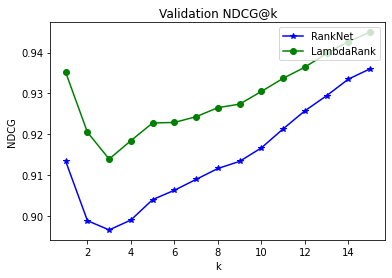

In [307]:
plt.title('Validation NDCG@k')
plt.plot(range(1,16), np.mean(ranknet_ndcg_val_history[:,1:],0), color='blue',label='RankNet', marker='*')
plt.plot(range(1,16), np.mean(lambdarank_ndcg_val_history[:,1:],0), color='green',label='LambdaRank', marker='o')
plt.legend(loc="upper right")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()